<font size="10">Hi, I'm Meatball.</font>
![title](meatball.webp)
I am a machine learning tool developed by @Noodles#7386 (franks@cs.uni-kl.de) to help you enjoy StepMania/ITG/DDR/or whatever you meat bags call your rhythm dance games. I am based on a sequence processing machine learning model called a transformer. This model is currently in its first stages of development, meaning I am in Alpha. *My human told me to say this, but I'm not really sure what it means.*

## Basic Setup

First of all, some basic setup stuff. Just run the cells below in order, and everything should be fine.

In [1]:
import os
import numpy as np
import simfile
from simfile.notes import NoteData, NoteType
from simfile.timing import TimingData
from simfile.timing.engine import TimingEngine
import onnxruntime
import matplotlib.pyplot as plt
from IPython import display

In [2]:
def get_note_level_encoding(beat):
    note_levels = [1,2,3,4,6,8] # These multiplied by 4 are the note levels
    for i in range(len(note_levels)):
        if beat%1*note_levels[i]%1<1e-6:
            return [j+1 for j in range(i+1) if note_levels[i] % note_levels[j] == 0]
    return len(note_levels)+1

def data_point(simfileInstance, chart):
    try:
        if simfileInstance.charts[chart].stepstype != 'dance-single':
            return None
        engine = TimingEngine(TimingData(simfileInstance, simfileInstance.charts[chart]))
        note_data = NoteData(simfileInstance.charts[chart])
        notes = []
        for note in note_data:
            if engine.hittable(note.beat) and \
            note.note_type in {NoteType.TAP, NoteType.HOLD_HEAD, NoteType.TAIL, NoteType.ROLL_HEAD}:
                notes += [(note.beat, engine.time_at(note.beat), note.column, note.note_type)]
        if len(notes) == 0:
            return None
        data=[]
        last_beat = -100000
        last_time = notes[0][1]-0.25
        note_count = 0
        number_of_beats = len(np.unique([beat for beat, time, column, type in notes]))
        song_duration = notes[-1][1] - notes[0][1]
        ongoing_holds = np.zeros(4)
        for beat, time, column, ntype in notes:
            if beat!=last_beat:
                note_count += 1
                last_beat = beat
                if len(data)>0:
                    data[-1][11 + 4:] += ongoing_holds
                data += [np.array([0]*19, dtype=np.float32)]
            
                data[-1][0] = engine.bpm_at(beat)/240
        
                data[-1][8] = note_count/number_of_beats
        
                data[-1][9] = time/song_duration
        
                data[-1][10] = min((time - last_time) * 4, 8)
                last_time = time
            
                data[-1][get_note_level_encoding(beat)]=1
                
            match ntype:
                case NoteType.TAP:
                    data[-1][11+column] = 1
                case NoteType.TAIL:
                    data[-1][11+4+column] = 1
                    ongoing_holds[column] = 0
                case NoteType.HOLD_HEAD|NoteType.ROLL_HEAD:
                    data[-1][11+column] = 1
                    ongoing_holds[column] = 1
        data[-1][11 + 4:] += ongoing_holds
    
        return np.vstack(data).T
    except:
        return None

def all_charts(link):
    out = []
    siblings = []
    try:
        for i in range(len(simfile.open(link, strict=False).charts)):
            chart = {'link':link, 'index':i, 'pack':link.split('\\')[-3], 'siblings':siblings}
            siblings += [chart]
            out += [chart]
    except:
        display(Markdown('{} appears to be broken'.format(root+'\\'+name)))
    return out

def get_charts(link):
    list = []
    for root, dirs, files in os.walk(link):
        ssc_present = False
        for name in files:
            if name.endswith((".ssc")):
                additions = all_charts(root+'\\'+name)
                list += additions
                ssc_present=ssc_present or len(additions)>0
        if not ssc_present:
            for name in files:
                if name.endswith((".sm")):
                    list += all_charts(root+'\\'+name)
    return list

ort_session = onnxruntime.InferenceSession("regressor.onnx")
def inference(inp):
    x = inp if inp.shape[1]>=60 else np.pad(inp, ((0,0),(0,60-inp.shape[1])))
    x_new = []
    for i in range(8):
        index = int(i*(x.shape[1]-60)/8)
        x_new += [x[:, index:index+60]]
    x=np.stack(x_new)[None,:]
    ort_inputs = {ort_session.get_inputs()[0].name: x} 
    ort_outs = ort_session.run(None, ort_inputs)
    return ort_outs[0][0,0]

def packs(charts):
    out = []
    for chart in charts:
        if chart['pack'] not in out:
            out+=[chart['pack']]
    return out

def filter_for_pack(charts, pack):
    out = []
    for chart in charts:
        if chart['pack']==pack:
            out+=[chart]
    return out

def index_to_threshold(index, n, charts):
    if index == 0:
        return charts[0]['prediction']-1
    if index == n:
        return charts[n-1]['prediction']+1
    return (charts[index-1]['prediction']+charts[index]['prediction'])/2

def calculate_thresholds_and_labels(charts):
    min_thresholds = []
    max_thresholds = []
    labels = []
    charts = sorted(charts, key=lambda x:x['prediction'])
    for chart in charts:
        if int(chart['meter']) not in labels:
            labels+=[int(chart['meter'])]
    labels = sorted(labels)
    sorted_classes = [int(chart['meter']) for chart in charts]
    for pi in range(len(labels)-1):
        i = labels[pi]
        binary_classes = [int(_class>i) for _class in sorted_classes]
        correct_count = sum(binary_classes)
        n = len(binary_classes)
        min_best_threshold = 0
        max_best_threshold = 0
        best_correct_count = correct_count
        for i, binary in enumerate(binary_classes):
            correct_count += 1-2*binary
            if correct_count > best_correct_count:
                min_best_threshold = i+1
                max_best_threshold = i+1
                best_correct_count = correct_count
            elif correct_count == best_correct_count:
                max_best_threshold = i+1
        min_thresholds+=[index_to_threshold(min_best_threshold, len(binary_classes), charts)]
        max_thresholds+=[index_to_threshold(max_best_threshold, len(binary_classes), charts)]
    return min_thresholds, max_thresholds, labels

def meter_of_chart(chart, thresholds, labels):
    for i in range(len(thresholds)):
        if chart['prediction']<thresholds[i]:
            return labels[i]
    return labels[-1]

def get_colors(number):
    base = [np.array([1,1,1], dtype=float),
            np.array([0,0.9,0.9], dtype=float),
            np.array([0,0.8,0], dtype=float),
            np.array([0.7,0.7,0], dtype=float),
            np.array([0.6,0,0], dtype=float),
            np.array([0.5,0,0.5], dtype=float),
            np.array([0,0,0.4], dtype=float),
            np.array([0,0,0], dtype=float)]
    additions = int(np.ceil((number-1)/(len(base)-1)))
    result = []
    for i in range(len(base)-1):
        a = base[i]
        b = base[i+1]
        for j in range(additions):
            result += [(1-j/additions)*a+(j/additions)*b]
    result += [base[-1]]
    return result

## Ranking

My first capability is to rank stepcharts on a very fine scale. To understand what is going on, I should explain what I do in more detail. The only exciting addition used in this document is a machine-learning model. Specifically, this model takes as input a chart and produces as output a real number like 72.1579352. This number has no inherent meaning, except that I consider a chart more difficult than another chart if this number is higher for one than the other. Now to visualize this, tell me where I can find some charts on your system. I will assign each of them a real number and then order, or rank, them into a long list from easiest to hardest. Depending on how many charts are contained in the directory you point me at, this might take a while, so I will only evaluate the first 1000 unless you comment out a line below.

In [3]:
link_to_your_Songs="F:\Visualization" #I think this is a good start?

all_charts = get_charts(link_to_your_Songs)
original_number_of_charts = len(all_charts)

pack_names = sorted(packs(all_charts))
print('These are all found packs: {}'.format(pack_names))

These are all found packs: ["Ben Speirs' SPEIRMIX GALAXY", 'DanceDanceRevolution X (AC) (Japan)', 'DanceDanceRevolution X2 (AC) (Japan)', 'DanceDanceRevolution X3 VS 2ndMIX (AC) (Japan)', 'DanceDanceRevolution XX', "forcednature's misc"]


In [4]:
if False:
    selected_packs = []
    selected_charts = []
    for pack_name in selected_packs:
        selected_charts += filter_for_pack(all_charts, pack_name)
else:
    selected_charts = all_charts
charts = selected_charts
charts = charts[:1000] #comment out this line if you want to wait longer and evaluate all charts
processed_charts = len(charts)
display.display(display.Markdown('I found {} charts in that folder and you selected {} charts to be processed'.format(original_number_of_charts, processed_charts)))

I found 6752 charts in that folder and you selected 1842 charts to be processed

In [5]:
raw_list = []
for i, chart in enumerate(charts):
    display.clear_output(wait=True)
    display.display(display.Markdown('I found {} charts in that folder. Processing... {}/{} done, {} usable.'.format(original_number_of_charts, i, processed_charts, len(raw_list))))
    simfileInstance = simfile.open(chart['link'], strict=False)
    x = data_point(simfileInstance, chart['index'])
    if x is not None:
        chart['prediction'] = inference(x)
        chart['title'] = simfileInstance.title if simfileInstance.titletranslit=='' or simfileInstance.titletranslit is None else simfileInstance.titletranslit
        chart['difficulty'] = simfileInstance.charts[chart['index']].difficulty
        chart['meter'] = simfileInstance.charts[chart['index']].meter
        raw_list += [chart]
charts = sorted(raw_list, key=lambda x:x['prediction'])
display.clear_output(wait=True)
display.display(display.Markdown('I found {} charts in that folder. Of the {} I processed, {} are dance-singles which I can use.'.format(original_number_of_charts, processed_charts, len(charts))))

I found 6752 charts in that folder. Of the 1842 I processed, 1039 are dance-singles which I can use.

In the following I produce a ranked list of all songs, from easiest to hardest.

In [6]:
for chart in charts:
    print(chart['pack'], chart['title'], chart['difficulty'], chart['meter'])

DanceDanceRevolution XX No Money Beginner 1
DanceDanceRevolution XX WONDERLAND (20th Anniversary Mix) Beginner 1
DanceDanceRevolution XX Walking on the Moon Beginner 1
DanceDanceRevolution XX trendset Beginner 1
DanceDanceRevolution XX How Long Beginner 2
DanceDanceRevolution XX Feel It Still Beginner 1
DanceDanceRevolution XX Funky Drivin' Beginner 1
DanceDanceRevolution XX Settin' the Scene Beginner 1
DanceDanceRevolution XX Best Day of My Life Beginner 1
DanceDanceRevolution XX White Eve Beginner 1
DanceDanceRevolution XX fancy cake!! Beginner 1
DanceDanceRevolution XX Shape of You Beginner 1
DanceDanceRevolution XX neogenesis Beginner 1
DanceDanceRevolution XX Generic Holiday Song Beginner 1
DanceDanceRevolution XX LOVE Beginner 1
DanceDanceRevolution XX Funky Life Beginner 1
DanceDanceRevolution XX Small Steps Beginner 1
DanceDanceRevolution XX Despacito (Remix) Beginner 1
DanceDanceRevolution XX Gayatri Beginner 1
DanceDanceRevolution XX New Rules Beginner 1
DanceDanceRevolution 

Well, now that you know how your charts compare, you probably want to use my amazingness amazingly and have me assign new difficulties to your charts, right? Well, of course, you do.

## Rerating

First, I assigned every chart a real number like 3.67543 or something similar. This does not directly translate into block difficulties. So first, I need some thresholds and corresponding labels. I will use these by looking for a chart and its real value for which the smallest threshold is still larger than that number and assign the corresponding label to that threshold. However, because you meat bags are not very consistent, using all charts to determine thresholds might lead to issues. So instead, my creator tried to use many different charts to get a rough estimate, for where the boundaries should lie. Feel free to change these how you seem fit.

In [7]:
itg_thresholds = [3, 10, 20, 30, 45, 55, 65, 75, 85, 95, 102, 105, 107.5, 108.25, 109]
itg_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

ddrx_thresholds = [-5, 2.5, 9, 15, 22.5, 30, 38, 46, 55, 62, 68, 74, 81, 87.5, 95, 100, 104, 106.5, 109]
ddrx_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

#replace the itg thresholds and labels with ddrx thresholds and labels if you want the ddrx scale.
my_thresholds = itg_thresholds
my_labels = itg_labels

display.display(display.Markdown('I will use the above as a definition of how charts should be rated.\n'
      'This means I can only assign difficulties from {} to {}.'.format( 
            min(my_labels),
            max(my_labels))))

I will use the above as a definition of how charts should be rated.
This means I can only assign difficulties from 1 to 16.

Now I can tell you the difficulty of any chart by just using these thresholds and labels.

In [8]:
for chart in charts:
    chart['new_meter'] = meter_of_chart(chart, my_thresholds, my_labels)
    chart['saved'] = False
    print('I would assign difficulty {} to {} {} {} {}'.format(
        chart['new_meter'], chart['pack'], chart['title'], chart['difficulty'], chart['meter']))

I would assign difficulty 1 to DanceDanceRevolution XX No Money Beginner 1
I would assign difficulty 1 to DanceDanceRevolution XX WONDERLAND (20th Anniversary Mix) Beginner 1
I would assign difficulty 1 to DanceDanceRevolution XX Walking on the Moon Beginner 1
I would assign difficulty 1 to DanceDanceRevolution XX trendset Beginner 1
I would assign difficulty 1 to DanceDanceRevolution XX How Long Beginner 2
I would assign difficulty 1 to DanceDanceRevolution XX Feel It Still Beginner 1
I would assign difficulty 1 to DanceDanceRevolution XX Funky Drivin' Beginner 1
I would assign difficulty 1 to DanceDanceRevolution XX Settin' the Scene Beginner 1
I would assign difficulty 1 to DanceDanceRevolution XX Best Day of My Life Beginner 1
I would assign difficulty 1 to DanceDanceRevolution XX White Eve Beginner 1
I would assign difficulty 1 to DanceDanceRevolution XX fancy cake!! Beginner 1
I would assign difficulty 1 to DanceDanceRevolution XX Shape of You Beginner 1
I would assign difficulty

Now, about saving new block difficulties. This can be a bit dangerous, since I dont want to override your favourite charts and break something. So, I will make a separate directory with the same structure as what you pointed me to, but containing changed StepMania files. However, because this can also take up quite a bit of memory, the following code block is disabled until you comment out an offending line.

In [9]:
switch = True
switch = False #comment out this line to allow saving
if switch:
    for chart in charts:
        chart['saved'] = False
    for chart in charts:
        if not chart['saved']:
            output_filename = 'rerated\\' +chart['link'][len(link_to_your_Songs)+1:]
            os.makedirs(os.path.dirname(output_filename), exist_ok=True)
            try:
                with simfile.mutate(chart['link'], output_filename=output_filename, strict=False) as simfileInstance:
                    for sibling in chart['siblings']:
                        if 'new_meter' in sibling:
                            simfileInstance.charts[sibling['index']].meter = str(sibling['new_meter'])
                            sibling['saved'] = True
            except:
                print('{} appears to be broken and cannot be stored. The difficulties should be:'.format(chart['link']))
                for sibling in chart['siblings']:
                    if 'new_meter' in sibling:
                        print(sibling['difficulty'], sibling['new_meter'])

Now you obviously think that's amazing, which is probably why you are not replying to anything I am saying. But there's actually more. Have you considered comparing thresholds for different packs?

## Comparing Packs

We can calculate optimal thresholds for any or all packs. Specifically, these are the thresholds that maximize the accuracy of my model using these thresholds on predicting the correct block difficulties for a pack. So let's do that.

In [10]:
pack_names = sorted(packs(charts))
display.display(display.Markdown('These are all available packs: {}'.format(pack_names)))

all_thresholds_and_labels = []
for pack_name in pack_names:
    pack_name_charts = filter_for_pack(charts, pack_name)
    min_thresholds, max_thresholds, labels = calculate_thresholds_and_labels(pack_name_charts)
    thresholds = [(t_min+t_max)/2 for t_min, t_max in zip(min_thresholds, max_thresholds)]
    all_thresholds_and_labels += [(pack_name, thresholds, min_thresholds, max_thresholds, labels)]

These are all available packs: ["forcednature's misc"]

I will also add in my creators definition.

In [11]:
all_thresholds_and_labels = [('Mine', my_thresholds, my_thresholds, my_thresholds, my_labels)] + all_thresholds_and_labels

Now how about visualizing those? Yeah, that's what we do next.

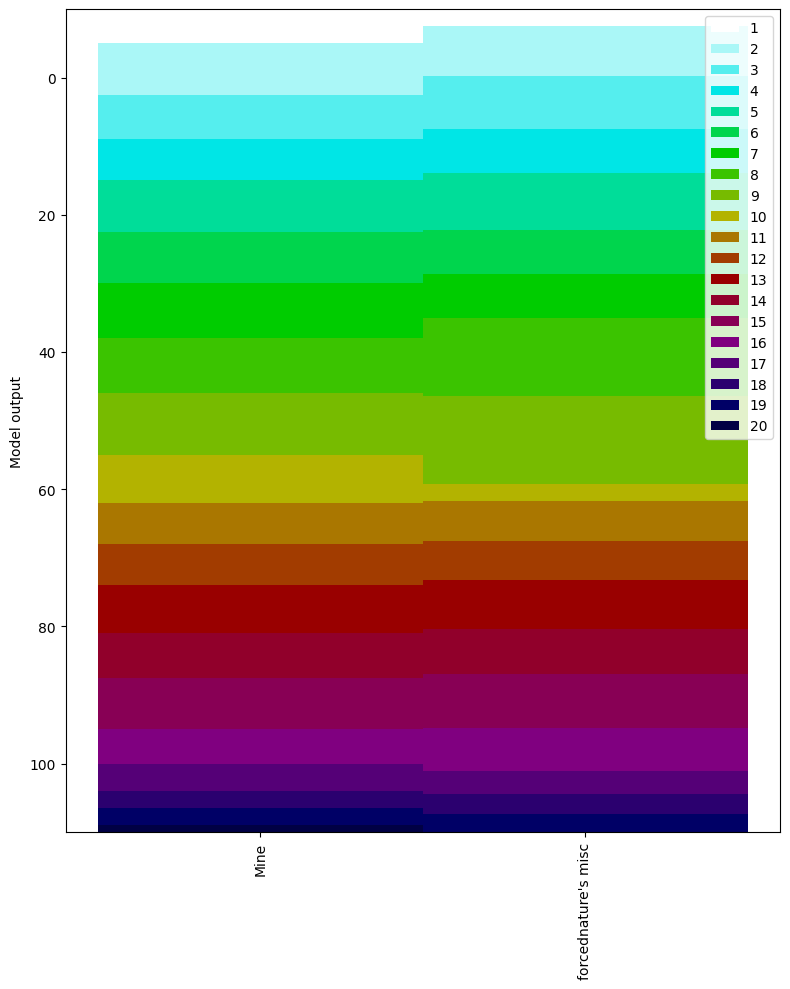

In [12]:
all_labels = [l1 for p, t, min_t, max_t, l in all_thresholds_and_labels for l1 in l]
min_label = max(min(all_labels), 1) # capped from below by 1  because of meme ratings
max_label = min(max(all_labels), 20)# capped from above by 16 because of meme ratings

#make a weird stairs plot that might not be stairs.
bars = np.zeros((max_label-min_label+2, len(all_thresholds_and_labels)), dtype=float)
bars -= 20
for i, (p, t, min_t, max_t, l) in enumerate(all_thresholds_and_labels):
    for j in range(len(t)):
        bars[l[j]-min_label+1,i]=t[j]

#fix bars, because some difficulties might not exist in a pack
for j in range(bars.shape[1]):
    for i in range(bars.shape[0]-1,-1,-1):
        if bars[i,j] == -20:
            bars[i,j] = 140
        else:
            break

for j in range(bars.shape[1]):
    last_t = -20
    for i in range(bars.shape[0]):
        if bars[i,j] == -20:
            bars[i,j] = last_t
        else:
            last_t = bars[i,j]

#visualize it
plt.rcParams["figure.figsize"] = (8,10)
plt.ylim(110,-10)
color_gradient = get_colors(len(bars)-1)
for i in range(len(bars)-1):
    plt.stairs(bars[i+1], baseline=bars[i], fill=True, label=str(i+min_label), color=color_gradient[i])
plt.legend()
plt.xticks([i+0.5 for i in range(len(all_thresholds_and_labels))], [p for p, t, min_t, max_t, l in all_thresholds_and_labels], rotation='vertical')
plt.ylabel('Model output')
plt.tight_layout()
try:
    os.makedirs('fig')
except:
    pass
plt.savefig('fig/test.png')

Now, this may confuse you. However, don't worry. I'm here to help. Probably some of your packs produce long, uniformly colored lines, and you are wondering why a 1 in one pack would be a 9 in another. Well, if you see long lines at the start or end of one pack, that is likely because that pack contains only some difficulties. Take, for instance, the pack BemaniBeats. This pack only includes difficulties 9-13, with an odd 420. How should I determine how difficulties 1-8 should be defined if they are absent? Exactly, I can't. So instead, I assume anything easier than the easiest chart in a pack should get the same label as that easiest chart, which in some cases might be a 9. The same holds for the opposite end of a pack, by the way.

## Visualizing Pack-Ranking Agreement

How about evaluating how strongly packs agree with my ranking? Using the optimal thresholds, I can assign each chart a new block difficulty, which can then be compared to its old one. The typical way to compare multiple of these is a confusion matrix. Which I do below for all the packs.

I would assign difficulty 1 to forcednature's misc Sorrows Beginner 1
I would assign difficulty 1 to forcednature's misc Yume no sora, yakusoku no basho Beginner 1
I would assign difficulty 1 to forcednature's misc Onigiri disco Beginner 1
I would assign difficulty 1 to forcednature's misc OOO Beginner 1
I would assign difficulty 1 to forcednature's misc Hanenaki shoujo uta Beginner 2
I would assign difficulty 1 to forcednature's misc Destiny Sword Beginner 1
I would assign difficulty 1 to forcednature's misc Sakura Reflection (P*Light Slayer Remix) Beginner 1
I would assign difficulty 1 to forcednature's misc Owari no shojo feat. Conyabata Beginner 2
I would assign difficulty 1 to forcednature's misc RPG syndrome Beginner 2
I would assign difficulty 1 to forcednature's misc Lost Memories (nmk Eurobeat mix) Beginner 2
I would assign difficulty 1 to forcednature's misc NEW SENSATION -mou anata shika mienai- Beginner 2
I would assign difficulty 1 to forcednature's misc GAMBOL (dfk SLC rm

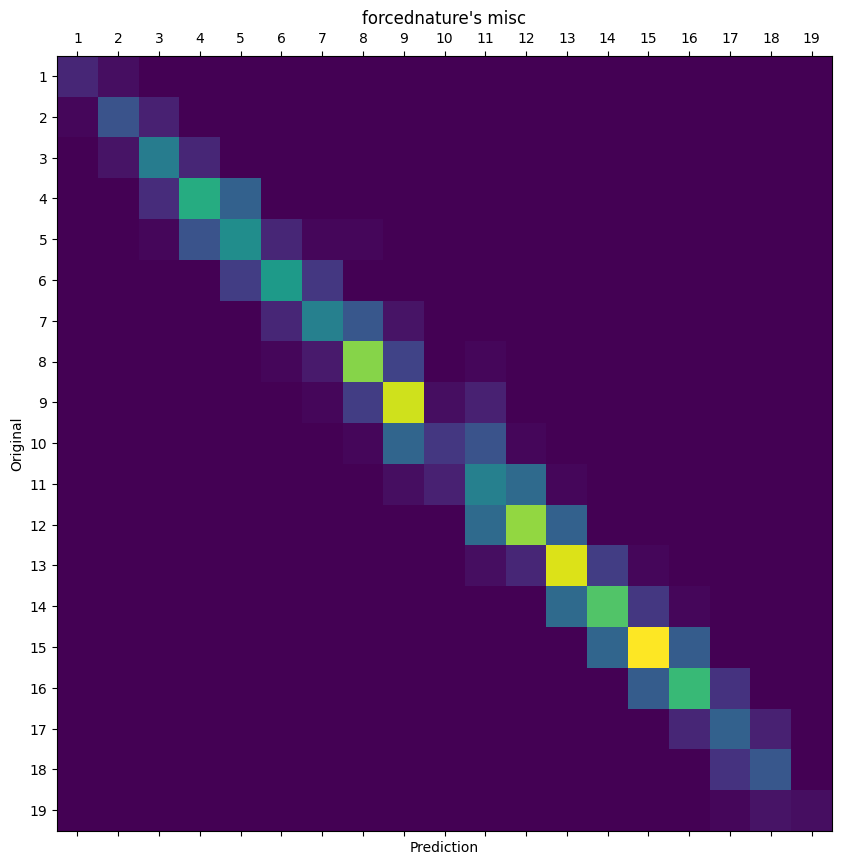

In [13]:
for pack_name, thresholds, min_thresholds, max_thresholds, labels in all_thresholds_and_labels:
    pack_name_charts = filter_for_pack(charts, pack_name)
    confusion_matrix = np.zeros((len(labels), len(labels)), dtype=int)
    for chart in pack_name_charts:
        prediction = len(thresholds)
        for i, t in enumerate(thresholds):
            if chart['prediction']<t:
                prediction = i
                break
        target = -1
        for i, l in enumerate(labels):
            if l==int(chart['meter']):
                target = i
                break
        confusion_matrix[target][prediction] += 1
    if len(pack_name_charts)!=0:
        plt.matshow(confusion_matrix)
        plt.xticks([i for i in range(len(labels))], labels)
        plt.xlabel('Prediction')
        plt.yticks([i for i in range(len(labels))], labels)
        plt.ylabel('Original')
        plt.title(pack_name)
        try:
            os.makedirs('fig')
        except:
            pass
        plt.savefig('fig/{}.png'.format(pack_name))
        plt.show()

That's about it. Can you think of more uses? Don't hesitate to contact my creator @Noodles#7386 (franks@cs.uni-kl.de) in that case.

I can also visualize the difficulty per time point within a chart. However, my creator is still working on making that work properly. I am still determining what the holdup is. He just always takes forever with these things.

## Difficulties Within a Chart

TODO